# Pointcloud Tree Analysis
An experimental notebook

We will compare and analyse isolated trees using three different point cloud sources:
1. _[AHN](https://www.ahn.nl) data_ (publicly available)
2. _Cyclo Media_
3. _Sonarski_

A visual impression of what the an isolated three looks like in the three datasets. 
This particular tree is located at 1219.13, 4874.34 (LTR: AHN, CycloMedia, Sonarski):

![Comparison of datasets (side-view)](../imgs/20_side.png)
![Comparison of datasets (top-view)](../imgs/20_top.png)

#### Import Modules

In [1]:
# Uncomment to load the local package rather than the pip-installed version.
# Add project src to path.
import set_path

In [2]:
# Import modules.
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull

import utils.math_utils as math_utils
import utils.plot_utils as plot_utils
import utils.las_utils as las_utils

#### Load datasets

In [3]:
ahn_tree_path = '../datasets/single_selection/single_121913_487434_AHN.las'
cyclo_tree_path = '../datasets/single_selection/single_121913_487434_Cyclo.las'
sonarski_tree_path = '../datasets/single_selection/single_121913_487434_Sonarski.las'

In [4]:
las_files = {
    'AHN': las_utils.read_las(ahn_tree_path), 
    'CycloMedia': las_utils.read_las(cyclo_tree_path),
    'Sonarski': las_utils.read_las(sonarski_tree_path)
}

## 1. Dataset statistics

In [5]:
las_utils.print_statistics(las_files['CycloMedia'])

Pointcloud Statistics:
------------------------
No. points: 168265
Mean distance: 0.04 m
x: 12.86 m [121906.94 121919.8 ]
y: 12.6 m [487427.54 487440.14]
z: 15.27 m [ 1.71 16.98]



#### Open3D experiments

In [6]:
cyclo_pcd = las_utils.to_o3d(las_files['CycloMedia'])
cyclo_pcd.estimate_normals(o3d.geometry.KDTreeSearchParamRadius(.15))
cyclo_pcd

PointCloud with 168265 points.

In [15]:
# Outlier Selection
def outlier_removal(pcd):
    print("Radius oulier removal")
    cl, ind = pcd.remove_radius_outlier(nb_points=2, radius=0.3)

    inlier_cloud = pcd.select_by_index(ind)
    outlier_cloud = pcd.select_by_index(ind, invert=True)
    outlier_cloud.paint_uniform_color([1, 0, 0])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

outlier_removal(cyclo_pcd)

Radius oulier removal


In [7]:
# Convex Hull
def pcd_convex_hull(pcd):
    hull, _ = pcd.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))
    o3d.visualization.draw_geometries([pcd, hull_ls])

pcd_convex_hull(cyclo_pcd)

![Convex Hull](../imgs/convex_hull.png)

In [ ]:
# Poisson Surface Reconstruction
def poisson_sr(pcd):
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
    o3d.visualization.draw_geometries([mesh])

poisson_sr(cyclo_pcd)

## Feature Extraction

**Tree height**

In [ ]:
# Option 1
# Substract tree pointcloud max and min.
def tree_height(las):
    height = las.xyz[:,2].max() - las.xyz[:,2].min()
    return height

# Option 2: 
# Compare tree cloud max with AHN (maaiveld) 
def tree_height_ahn(las, ahn):
    ground_z = None # TODO: z value at root.
    tree_max_z = las.xyz[:,2].max()
    height = tree_max_z - ground_z

**Base height**

Two options:
1. Substract tree pointcloud max and min.
2. Compare tree cloud max with AHN (maaiveld)

In [24]:
def pcd_to_grid(pcd, bin_size=.1):
        points = np.asarray(pcd.points)
        min_x, max_x = min(points[:, 0])-.5*bin_size, max(points[:, 0])+.5*bin_size
        min_y, max_y = min(points[:, 1])-.5*bin_size, max(points[:, 1])+.5*bin_size
        min_z, max_z = min(points[:, 2])-.5*bin_size, max(points[:, 2])+.5*bin_size
        dimx = max_x - min_x
        dimy = max_y - min_y
        dimz = max_z - min_z
        bins = [np.uint(dimx/bin_size), np.uint(dimy/bin_size), np.uint(dimz/bin_size)]
        hist_range = [[min_x, max_x], [min_y, max_y], [min_z, max_z]]
        
        counts, edges = np.histogramdd(points, range=hist_range, bins=bins)
        origin = (hist_range[0][0]+bin_size/2,hist_range[1][0]+bin_size/2, hist_range[2][0]+bin_size/2)
        grid = counts > 0

        return grid, edges, bins, hist_range, origin

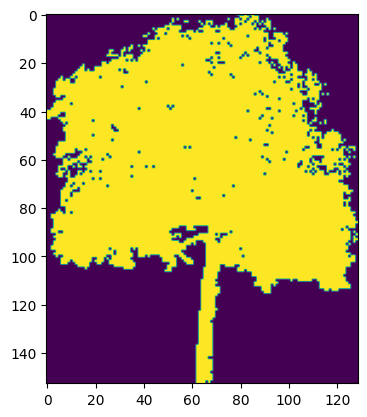

In [44]:
grid = pcd_to_grid(cyclo_pcd)[0]
plt.imshow(np.flip(np.sum(grid, axis=1).T>0))

Base height: 3.68


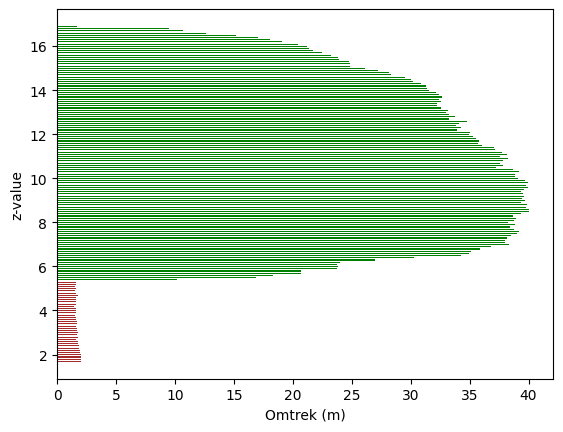

In [187]:
# TODO: prone to hanging branches 

pcd = cyclo_pcd

bin_size = 0.15
points = np.asarray(pcd.points)
min_z, max_z = min(points[:, 2])-bin_size, max(points[:, 2])+bin_size
bins = np.arange(min_z, max_z, 0.1)

slice_ind = np.digitize(points[:,2], bins, right=True)

data = []
hulls = []
for i in np.unique(slice_ind):
    slice_mask = slice_ind==i
    if np.sum(slice_mask) > 3:
        slice_pts = points[slice_mask, :2]
        hull_pts = slice_pts[ConvexHull(slice_pts).vertices]
        hull_poly = Polygon(hull_pts)
        omtrek = hull_poly.length
        z = bins[i] - .5*bin_size
        data.append((z, omtrek))
        hulls.append(hull_poly)

base_i = np.argmax(np.array(data)[1:,1] - np.array(data)[:-1,1]  > .5)+1
plt.barh(np.array(data)[:base_i,0], np.array(data)[:base_i,1], height=0.05, color='brown')
plt.barh(np.array(data)[base_i:,0], np.array(data)[base_i:,1], height=0.05, color='green')
plt.ylabel('z-value')
plt.xlabel('Omtrek (m)')

base_height = data[base_i][0] - min(points[:, 2])
print('Base height:', np.round(base_height,2))